In [7]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

In [2]:
np.random.seed(0)

In [3]:
# Generate data
X, y = make_blobs(n_samples=1000, random_state=42, cluster_std=5.0)
X_train, y_train = X[:600], y[:600]
X_valid, y_valid = X[600:800], y[600:800]
X_train_valid, y_train_valid = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [4]:
X_train

array([[-5.46318783, -8.17463446],
       [-3.16915033, -5.38364669],
       [ 7.4315134 ,  2.35319664],
       ...,
       [ 5.16675637, -4.69695779],
       [ 4.8802726 ,  6.42293504],
       [ 1.87876361,  5.13782877]])

In [5]:
np.shape(X_train)

(600, 2)

In [8]:
# Import and organize data. Use only FSR data

# Import and organize data

filepath = "/Users/salatiemann/Documents/UC Berkeley/Year 3 Sem 2 (Spring 2020)/Tensegrity-HRI/Data_sala/test"
test_numbers = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20',
      '21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40',
      '41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60',
      '61','62','63','64','65','66','67','68','69','70','71','72']
data = []
for num in test_numbers:
    filename = filepath + num + '.csv'
    d = pd.read_csv(filename, names = ["time", "IND", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", 
                                   "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12","ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d.drop(columns = ["IND", "time"])
    d1 = d1.drop(columns = ["ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d1.to_numpy()
    d1 = d1[0:7000]
    data.append(d1)

In [10]:
np.shape(data)

(72, 7000, 12)

In [94]:
y = [0,0,0,3,1,1,1,1,1,1,3,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,1,1,1,1,0,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,2,3,3,3,3,3,2,2,2,0,0,1,1,2,2,3,3]

In [14]:
# FEATURES

# This feature returns the percent of data points that are below 75% of the max

def three_quarters(column,percent):
    max = np.max(column)
    three_fourths = percent*max
    e = []
    j=0
    for i in range(len(column)):
        if column[i] <= .75*np.max(column):
            j+=1
    return j/len(column)

# This feature takes the max of each column, takes the data point [change_factor] ms after that, and then normalizes 
# the difference

def change_in_max(column, change_factor):
    max_index = np.argmax(column)
    minus_change_index = max_index - change_factor
    if minus_change_index > 0:
        minus_change_value = column[minus_change_index]
    else:
        minus_change_index = max_index + change_factor
        minus_change_value = column[minus_change_index]
    diff = np.max(column) - minus_change_value
    normalized = diff/np.std(column)
    return normalized

# This function takes all 72 data points of size (7001,16) and puts them into a feature-engineered array.
# Desired shape: 72 data points of size (6,16) --> (72,6,16)

def features(array, three_quarters_percent, change_in_max_change_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    number_of_features = 6
    condensed_data = np.zeros((len_dataset,number_of_features,number_of_columns))
    for j in range(72):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((number_of_features,number_of_columns),dtype=np.float64)
        for i in range(number_of_columns):
            column = data_point[:,i]
            D[0,i] = np.mean(column)
            D[1,i] = np.var(column)
            D[2,i] = np.max(column)-np.min(column)
            D[3,i] = three_quarters(column,three_quarters_percent)
            D[4,i] = change_in_max(column,change_in_max_change_factor)
            D[5,i] = np.sum(column)/np.max(column) #or np.std(column). MAX WORKS THE BEST! went from 80% or so to 100%
        condensed_data[j]=D
        if np.mod(j,6) == 0:
            print(j, end=" ")
    return condensed_data

In [15]:
# Condense data into averages over a specified number of data points

def condense(array, condense_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    length = len(array[0])
    condensed_length = int((length/condense_factor))
    condensed_data = np.zeros((len_dataset,condensed_length,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        for k in range(number_of_columns):
            column = data_point[:,k]
            for i in range(condensed_length):
                condensed_data[j][i,k] = np.mean(column[i*condense_factor:(i*condense_factor+condense_factor)])
    return condensed_data

In [16]:
# Takes the max of all features from the 16 datapoints. Output is 72 sets of 1 by 6 data, where each of the 6 points
# is the max of each feature from the set. 

def everything_max(array):
    len_dataset, num_features, num_datapoints = np.shape(array)
    maxed_data = np.zeros((len_dataset, 1, num_features))
    for i in range(len_dataset):
        datapoint = array[i]
        D = np.zeros((1, num_features))
        for j in range(num_features):
            D[0,j] = max(datapoint[:,j])
        maxed_data[i] = D
    return maxed_data

In [17]:
# Normalize and feature-ify the data
normalized_data = data/np.max(data)
normalized_featured_data = features(normalized_data,.75,50)
np.shape(normalized_featured_data)

# Make dataset that only has max of each feature
maxed_data = everything_max(normalized_featured_data)

0 6 12 18 24 30 36 42 48 54 60 66 

In [18]:
# Turn 3D array into 2D array
np.shape(maxed_data)

(72, 1, 6)

In [74]:
# Turn 3D array into 2D array

def two_d(maxed_data):
    len_data, _, num_points = np.shape(maxed_data)
    data = np.zeros((len_data, num_points))
    for i in range(len(maxed_data)):
        data[i] = maxed_data[i][0]
    return data

x = two_d(maxed_data)

In [139]:
x_train, y_train = x[:28], y[:28]
x_valid, y_valid = x[28:56], y[28:56]
x_train_valid, y_train_valid = x[:56], y[:56]
x_test, y_test = x[56:], y[56:]

In [140]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(x_train_valid, y_train_valid)
clf_probs = clf.predict_proba(x_test)
score = log_loss(y_test, clf_probs)

In [141]:
# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(x_train, y_train)
clf_probs = clf.predict_proba(x_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(x_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(x_test)
sig_score = log_loss(y_test, sig_clf_probs)

In [142]:
clf_probs

array([[0.4 , 0.  , 0.  , 0.6 ],
       [0.52, 0.  , 0.  , 0.48],
       [0.76, 0.  , 0.  , 0.24],
       [0.44, 0.  , 0.  , 0.56],
       [0.88, 0.  , 0.  , 0.12],
       [0.  , 0.28, 0.72, 0.  ],
       [0.  , 0.28, 0.72, 0.  ],
       [0.  , 0.24, 0.76, 0.  ],
       [0.92, 0.  , 0.08, 0.  ],
       [0.76, 0.04, 0.  , 0.2 ],
       [0.  , 0.48, 0.52, 0.  ],
       [0.4 , 0.24, 0.36, 0.  ],
       [0.  , 0.32, 0.68, 0.  ],
       [0.  , 0.24, 0.76, 0.  ],
       [0.88, 0.  , 0.  , 0.12],
       [0.68, 0.  , 0.  , 0.32]])

In [134]:
y_test

[3, 3, 3, 3, 3, 2, 2, 2, 0, 0, 1, 1, 2, 2, 3, 3]

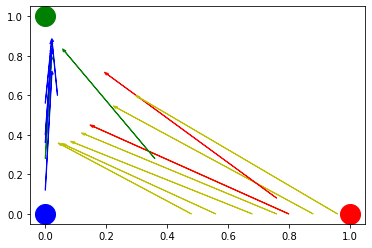

In [115]:
# Plot changes in predicted probabilities via arrows
plt.figure()
colors = ["r", "g", "b","y"]
for i in range(clf_probs.shape[0]):
    plt.arrow(clf_probs[i, 0], clf_probs[i, 1],
              sig_clf_probs[i, 0] - clf_probs[i, 0],
              sig_clf_probs[i, 1] - clf_probs[i, 1],
              color=colors[y_test[i]], head_width=1e-2)

# Plot perfect predictions
plt.plot([1.0], [0.0], 'ro', ms=20, label="Class 1")
plt.plot([0.0], [1.0], 'go', ms=20, label="Class 2")
plt.plot([0.0], [0.0], 'bo', ms=20, label="Class 3")

In [114]:
clf_probs.shape[0]
np.shape(y_test)
y_test[0]

3